# Advent of Haystack: Day 9
_Make a copy of this Colab to start!_

In this challenge, you'll help Santa build a self-reflecting gift selection agent using Haystack and MongoDB Atlas! 🎅

The agent will help optimize gift selections based on children's wishlists and budget constraints, using MongoDB Atlas vector search for semantic matching and implementing self-reflection to ensure the best possible gift combinations.

**Components to use in this challenge:**
- [`OpenAITextEmbedder`](https://docs.haystack.deepset.ai/docs/openaitextembedder) for  query embedding
- [`MongoDBAtlasEmbeddingRetriever`](https://docs.haystack.deepset.ai/docs/) for finding relevant gifts
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for  generating responses
- Custom `GiftChecker` component for self-reflection

## Setup

First, let's install the required packages:

In [1]:
! uv pip install haystack-ai mongodb-atlas-haystack tiktoken datasets colorama -q --upgrade openai

## Configure Environment

- [OpenAI API Key](https://platform.openai.com/api-keys) if you'd like to use OpenAI embedding and text generation models
- [MongoDB Atlas project](https://www.mongodb.com/docs/atlas/getting-started/) with an Atlas cluster (free tier works). [Detailed Tutorial](https://www.mongodb.com/docs/guides/atlas/cluster/#create-a-cluster)
- Get your [connection string](https://www.mongodb.com/docs/atlas/tutorial/connect-to-your-cluster/#connect-to-your-atlas-cluster) and have `0.0.0.0/0` address in your network access list.
- Connection string looks like this `mongodb+srv://<db_username>:<db_password>@<clustername>.xxxxx.mongodb.net/?retryWrites=true...`

Set up your MongoDB Atlas and OpenAI credentials:

In [2]:
import os
import getpass
import re

conn_str = getpass.getpass("Enter your MongoDB connection string:")
conn_str = (re.sub(r'appName=[^\s]*', 'appName=devrel.ai.haystack_partner', conn_str)
            if 'appName=' in conn_str
            else conn_str + ('&' if '?' in conn_str else '?') + 'appName=devrel.ai.haystack_partner')
os.environ['MONGO_CONNECTION_STRING']=conn_str
os.environ['OPENAI_API_KEY'] = getpass.getpass("Enter your OpenAI API Key:")

## Sample Gift Dataset

Here's a starter dataset of gifts. Feel free to expand it with more options!

In [3]:
dataset = {
    "train": [
    {
        "title": "LEGO Star Wars Set",
        "price": "$49.99",
        "description": "Build your own galaxy with this exciting LEGO Star Wars set",
        "category": "Toys",
        "age_range": "7-12"
    },
    {
        "title": "Remote Control Car",
        "price": "$29.99",
        "description": "Fast and fun RC car with full directional control",
        "category": "Toys",
        "age_range": "6-10"
    },
    {
        "title": "Art Set",
        "price": "$24.99",
        "description": "Complete art set with paints, brushes, and canvas",
        "category": "Arts & Crafts",
        "age_range": "5-15"
    },
    {
        "title": "Science Kit",
        "price": "$34.99",
        "description": "Educational science experiments kit",
        "category": "Educational",
        "age_range": "8-14"
    },
    {
        "title": "Dollhouse",
        "price": "$89.99",
        "description": "Beautiful wooden dollhouse with furniture",
        "category": "Toys",
        "age_range": "4-10"
    },
    {
        "title": "Building Blocks Set",
        "price": "$39.99",
        "description": "Classic wooden building blocks in various shapes and colors",
        "category": "Educational",
        "age_range": "3-8"
    },
    {
        "title": "Board Game Collection",
        "price": "$44.99",
        "description": "Set of 5 classic family board games",
        "category": "Games",
        "age_range": "6-99"
    },
    {
        "title": "Puppet Theater",
        "price": "$59.99",
        "description": "Wooden puppet theater with 6 hand puppets",
        "category": "Creative Play",
        "age_range": "4-12"
    },
    {
        "title": "Robot Building Kit",
        "price": "$69.99",
        "description": "Build and program your own robot with this STEM kit",
        "category": "Educational",
        "age_range": "10-16"
    },
    {
        "title": "Play Kitchen",
        "price": "$79.99",
        "description": "Realistic play kitchen with sounds and accessories",
        "category": "Pretend Play",
        "age_range": "3-8"
    },
    {
        "title": "Musical Instrument Set",
        "price": "$45.99",
        "description": "Collection of kid-friendly musical instruments",
        "category": "Music",
        "age_range": "3-10"
    },
    {
        "title": "Sports Equipment Pack",
        "price": "$54.99",
        "description": "Complete set of kids' sports gear including ball, bat, and net",
        "category": "Sports",
        "age_range": "6-12"
    },
    {
        "title": "Magic Tricks Kit",
        "price": "$29.99",
        "description": "Professional magic set with instruction manual",
        "category": "Entertainment",
        "age_range": "8-15"
    },
    {
        "title": "Dinosaur Collection",
        "price": "$39.99",
        "description": "Set of 12 detailed dinosaur figures with fact cards",
        "category": "Educational",
        "age_range": "4-12"
    },
    {
        "title": "Craft Supply Bundle",
        "price": "$49.99",
        "description": "Comprehensive craft supplies including beads, yarn, and tools",
        "category": "Arts & Crafts",
        "age_range": "6-16"
    },
    {
        "title": "Coding for Kids Set",
        "price": "$64.99",
        "description": "Interactive coding kit with programmable robot and game cards",
        "category": "STEM",
        "age_range": "8-14"
    },
    {
        "title": "Dress Up Trunk",
        "price": "$49.99",
        "description": "Collection of costumes and accessories for imaginative play",
        "category": "Pretend Play",
        "age_range": "3-10"
    },
    {
        "title": "Microscope Kit",
        "price": "$59.99",
        "description": "Real working microscope with prepared slides and tools",
        "category": "Science",
        "age_range": "10-15"
    },
    {
        "title": "Outdoor Explorer Kit",
        "price": "$34.99",
        "description": "Nature exploration set with binoculars, compass, and field guide",
        "category": "Outdoor",
        "age_range": "7-12"
    },
    {
        "title": "Art Pottery Studio",
        "price": "$69.99",
        "description": "Complete pottery wheel set with clay and glazing materials",
        "category": "Arts & Crafts",
        "age_range": "8-16"
    }
]
}

## Initialize MongoDB Atlas

First, we need to set up our MongoDB Atlas collection and create a vector search index. This step is crucial for enabling semantic search capabilities:

In [4]:
 # Create collection gifts and add the vector index


from pymongo import MongoClient
from bson import json_util
from pymongo.operations import SearchIndexModel
import json
import time

client = MongoClient(os.environ['MONGO_CONNECTION_STRING'])
db = client['santa_workshop']
collection = db['gifts']

db.create_collection("gifts")


## create index
search_index_model = SearchIndexModel(
  definition={
    "fields": [
      {
        "type": "vector",
        "numDimensions": 1536,
        "path": "embedding",
        "similarity": "cosine"
      },
    ]
  },
  name="vector_index",
  type="vectorSearch",
)
result = collection.create_search_index(model=search_index_model)
print("New search index named " + result + " is building.")
# Wait for initial sync to complete
print("Polling to check if the index is ready. This may take up to a minute.")
predicate=None
if predicate is None:
  predicate = lambda index: index.get("queryable") is True
while True:
  indices = list(collection.list_search_indexes(result))
  if len(indices) and predicate(indices[0]):
    break
  time.sleep(5)
print(result + " is ready for querying.")
client.close()

New search index named vector_index is building.
Polling to check if the index is ready. This may take up to a minute.
vector_index is ready for querying.


## Initialize Document Store and Index Documents

Now let's set up the [MongoDBAtlasDocumentStore](https://docs.haystack.deepset.ai/docs/mongodbatlasdocumentstore) and index our gift data:

In [5]:
from haystack import Pipeline, Document
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack_integrations.document_stores.mongodb_atlas import MongoDBAtlasDocumentStore
from bson import json_util

# Initialize document store
document_store = MongoDBAtlasDocumentStore(
    database_name="santa_workshop",
    collection_name="gifts",
    vector_search_index="vector_index"
)

# Convert dataset to Haystack documents
insert_data = [
    Document(content=gift['title'], meta=json_util.loads(json_util.dumps(gift)))
    for gift in dataset['train']
]

# Create and run indexing pipeline
doc_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)
doc_embedder = OpenAIDocumentEmbedder(
    model="text-embedding-3-small",
    meta_fields_to_embed=["description"]  # Include description in embeddings
)

indexing_pipe = Pipeline()
indexing_pipe.add_component(instance=doc_embedder, name="doc_embedder")
indexing_pipe.add_component(instance=doc_writer, name="doc_writer")
indexing_pipe.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipe.run({"doc_embedder": {"documents": insert_data}})

/home/kalki/genAI/adventOfHaystack/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating embeddings: 1it [00:02,  2.27s/it]


{'doc_embedder': {'meta': {'model': 'text-embedding-3-small',
   'usage': {'prompt_tokens': 241, 'total_tokens': 241}}},
 'doc_writer': {'documents_written': 20}}

## TODO: Create Gift Selection Pipeline

Now comes the fun part! Create a pipeline that can:
1. Take a gift request query
2. Find relevant gifts using vector search
3. Self-reflect on selections to optimize for budget and preferences

**HINT:** Learn how to write your component in [Docs: Creating Custom Components](https://docs.haystack.deepset.ai/docs/custom-components)

Here's the basic structure to get you started:

In [6]:
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.retrievers.mongodb_atlas import MongoDBAtlasEmbeddingRetriever
from haystack.components.embedders import OpenAITextEmbedder
from colorama import Fore
from typing import List
from haystack import component


""" 
# TODO: Create a GiftChecker component for self-reflection
@component
class GiftChecker:
    @component.output_types(gifts_to_check=str, gifts=str)
    def run(self, replies: List[str]):
        # Your code here!
        # Hint: Check if the selection is optimal ('DONE') or needs improvement
        
        pass """


@component
class GiftChecker:
    @component.output_types(gifts_to_check=str, gifts=str)
    def run(self, replies: List[str]):
        """
        Check if gift selection is optimal or needs improvement.
        
        Args:
            replies: List of responses from the gift selection process
            
        Returns:
            gifts_to_check: Gift that needs further optimization
            gifts: Final gift selection
        """
        
        # If the selection is marked as DONE, return it as final
        if "DONE" in replies[0]:
            return {"gifts": replies[0].replace('DONE', '')}
            
        # If not DONE, send back for optimization
        print(Fore.RED + "Reflecting on gifts\n", replies[0])
        return {"gifts_to_check": replies[0]}

# TODO: Create your prompt template
prompt_template = """
    You are Santa's gift selection assistant. Below you have a list of available gifts with their prices.
    Based on the child's wishlist and budget, suggest appropriate gifts that maximize joy while staying within budget.

    Available Gifts:
    {% for doc in documents %}
        Gift: {{ doc.content }}
        Price: {{ doc.meta['price']}}
        Age Range: {{ doc.meta['age_range']}}
    {% endfor %}

    Query: {{query}}
    {% if gifts_to_check %}
        Previous gift selection: {{gifts_to_check[0]}}
        Can we optimize this selection for better value within budget?
        If optimal, say 'DONE' and return the selection
        If not, suggest a better combination
    {% endif %}


    Gift Selection:
"""



In [7]:
# TODO: Create and connect your pipeline components
gift_pipeline = Pipeline(max_runs_per_component=5)

In [8]:
# Hint: You'll need:
# - OpenAITextEmbedder for query embedding
# - MongoDBAtlasEmbeddingRetriever for finding relevant gifts
# - PromptBuilder for creating the prompt
# - GiftChecker for self-reflection
# - OpenAIGenerator for generating responses
text_embedder = OpenAITextEmbedder(model="text-embedding-3-small")
retriever = MongoDBAtlasEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini")
gift_checker = GiftChecker()

gift_pipeline.add_component("text_embedder", text_embedder)
gift_pipeline.add_component("retriever", retriever)
gift_pipeline.add_component("prompt_builder", prompt_builder)
gift_pipeline.add_component("llm", generator)
gift_pipeline.add_component("gift_checker", gift_checker)

In [9]:
# Connect your components here!
# Hint: Think about the flow of data between components
gift_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
gift_pipeline.connect("retriever", "prompt_builder.documents")
gift_pipeline.connect("prompt_builder.prompt", "llm.prompt")
gift_pipeline.connect("llm.replies", "gift_checker.replies")
gift_pipeline.connect("gift_checker.gifts_to_check", "prompt_builder.gifts_to_check")

🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: MongoDBAtlasEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - gift_checker: GiftChecker
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> gift_checker.replies (List[str])
  - gift_checker.gifts_to_check -> prompt_builder.gifts_to_check (str)

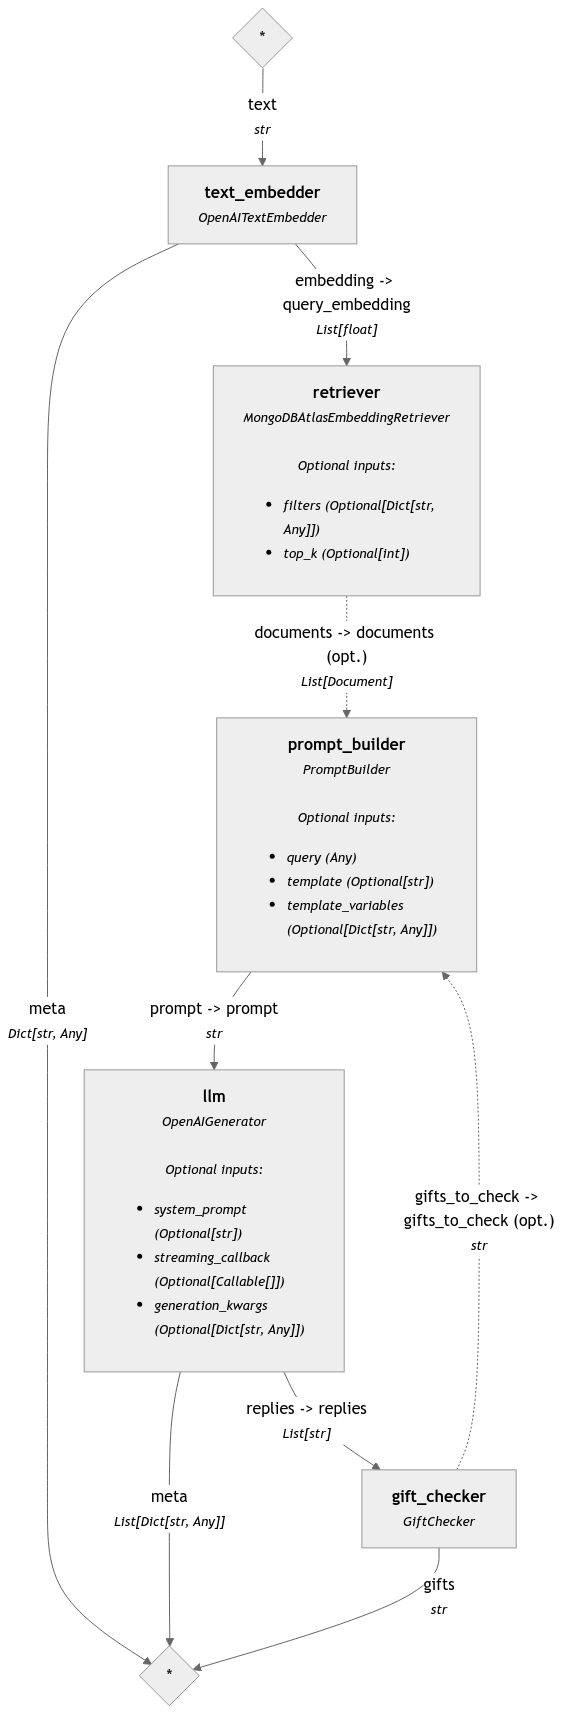

In [10]:
gift_pipeline.show()

## Test Your Agent

Once you've built your pipeline, test it with different scenarios:

In [11]:
# Test queries to try:
queries = [
    "Find gifts for a 9-year-old who loves science and building things. Budget: $100",
    "Need gifts for a creative 6-year-old interested in art. Budget: $50",
    "Looking for educational toys for a 12-year-old. Budget: $75"
]

# TODO: Try your pipeline with a query
query = queries[0]  # Choose a query to test



In [15]:
# Run the pipeline and print the results
results = gift_pipeline.run(
    {'text_embedder':{'text': query},
     'retriever':{'top_k':5},
     'prompt_builder': {'template_variables': {'query':query}}
     }
    )

Reflecting on gifts
 For a 9-year-old who loves science and building things and has a budget of $100, here are the suggested gifts:

1. **Science Kit** - $34.99
   - Great for exploring scientific concepts and hands-on activities.
  
2. **Musical Instrument Set** - $45.99
   - While not directly related to science or building, it can spark creativity and interest in play-based learning.

3. **Total Cost**: $34.99 + $45.99 = $80.98

Alternatively, if the focus is strictly on science and building:

1. **Science Kit** - $34.99
2. **Dress Up Trunk** - $49.99
   - This gift can encourage imaginative play, which complements the science and building theme indirectly.

3. **Total Cost**: $34.99 + $49.99 = $84.98 

With a budget of $100, both of these combinations are within range and will provide a variety of engaging activities! 

**Final Recommendation**: 
- **Option 1**: Science Kit + Musical Instrument Set for $80.98
- **Option 2**: Science Kit + Dress Up Trunk for $84.98

These choices wi

/home/kalki/genAI/adventOfHaystack/.venv/lib/python3.12/site-packages/haystack/core/pipeline/pipeline.py:523: RuntimeWarning: Pipeline is stuck running in a loop. Partial outputs will be returned. Check the Pipeline graph for possible issues.
  warn(RuntimeWarning(msg))


In [17]:
print(results['gift_checker']['gifts'])

For a 9-year-old who loves science and building things, we can consider the following gifts within the $100 budget:

1. **Science Kit** - $34.99
   - Age Range: 8-14
2. **Dress Up Trunk** - $49.99
   - Age Range: 3-10

Total: $34.99 + $49.99 = $84.98

This combination leaves us with a remaining budget of $15.02, and it fully reflects the child's interests in science and creativity.

However, prioritizing the love for science and building, we can also choose:

1. **Science Kit** - $34.99
2. **Robot Building Kit** - $69.99

The total would be $34.99 + $69.99 = $104.98, which exceeds the budget.

Another approach would be:

1. **Science Kit** - $34.99
2. **Coding for Kids Set** - $64.99

Total: $34.99 + $64.99 = $99.98, which fits within the budget of $100.

Given these evaluations, the better combination that maximizes joy and fits the budget would be:

**Gift Selection:**
- Science Kit - $34.99
- Coding for Kids Set - $64.99

Total: $99.98




## Next Steps (Bonus)

Once you have the basic pipeline working, try these extensions:
1. Add sentiment analysis to evaluate gift joy potential
2. Implement gift bundle optimization
3. Add previous gift tracking to ensure variety
4. Enhance the prompt to consider seasonal availability
5. Add gift wrapping suggestions based on the selected gifts

Good luck! 🎄✨